## Valores missing, outlier y correlaciones

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.impute import KNNImputer
import scipy.stats as ss
import warnings

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

In [2]:
def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype!=float) & (dataset[i].dtype!=int):
            unicos = int(len(np.unique(dataset[i].dropna(axis=0, how='all'))))
            if unicos < 100:
                lista_variables_categoricas.append(i)
            else:
                other.append(i)

    return lista_variables_categoricas, other

def plot_feature(df, col_name, isContinuous, target):
    """
    Visualize a variable with and without faceting on the loan status.
    - df dataframe
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    count_null = df[col_name].isnull().sum()
    if isContinuous:
        
        sns.histplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(col_name)
    ax1.set_ylabel('Count')
    ax1.set_title(col_name+ ' Numero de nulos: '+str(count_null))
    plt.xticks(rotation = 90)


    if isContinuous:
        sns.boxplot(x=df[col_name], y=df[target], ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(col_name + ' by '+target)
    else:
        data = df.groupby(col_name)[target].value_counts(normalize=True).to_frame('proportion').reset_index() 
        data.columns = [i, target, 'proportion']
        #sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        sns.barplot(x = col_name, y = 'proportion', hue= target, data = data, saturation=1, ax=ax2)
        ax2.set_ylabel(target+' fraction')
        ax2.set_title(target)
        plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    
    plt.tight_layout()
    
def get_corr_matrix(dataset = None, metodo='pearson', size_figure=[10,8]):
    # Para obtener la correlación de Spearman, sólo cambiar el metodo por 'spearman'

    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    # Compute the correlation matrix
    corr = dataset.corr(method=metodo) 
    # Set self-correlation to zero to avoid distraction
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=size_figure)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, center=0,
                square=True, linewidths=.5,  cmap ='viridis' ) #cbar_kws={"shrink": .5}
    plt.show()
    
    return 0

def get_deviation_of_mean_perc(pd_loan, list_var_continuous, target, multiplier):
    """
    Devuelve el porcentaje de valores que exceden del intervalo de confianza
    :type series:
    :param multiplier:
    :return:
    """
    pd_final = pd.DataFrame()
    
    for i in list_var_continuous:
        
        series_mean = pd_loan[i].mean()
        series_std = pd_loan[i].std()
        std_amp = multiplier * series_std
        left = series_mean - std_amp
        right = series_mean + std_amp
        size_s = pd_loan[i].size
        
        perc_goods = pd_loan[i][(pd_loan[i] >= left) & (pd_loan[i] <= right)].size/size_s
        perc_excess = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size/size_s
        
        if perc_excess>0:    
            pd_concat_percent = pd.DataFrame(pd_loan[target][(pd_loan[i] < left) | (pd_loan[i] > right)]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            print(pd_concat_percent)
            #pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_outlier_values'] = pd_loan[i][(pd_loan[i] < left) | (pd_loan[i] > right)].size
            pd_concat_percent['porcentaje_sum_null_values'] = perc_excess
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    print()
    return pd_final


def get_percent_null_values_target(pd_loan, list_var_continuous, target):

    pd_final = pd.DataFrame()
    for i in list_var_continuous:
        if pd_loan[i].isnull().sum()>0:
            pd_concat_percent = pd.DataFrame(pd_loan[target][pd_loan[i].isnull()]\
                                            .value_counts(normalize=True).reset_index()).T
            pd_concat_percent.columns = [pd_concat_percent.iloc[0,0], 
                                         pd_concat_percent.iloc[0,1]]
            pd_concat_percent = pd_concat_percent.drop('index',axis=0)
            pd_concat_percent['variable'] = i
            pd_concat_percent['sum_null_values'] = pd_loan[i].isnull().sum()
            pd_concat_percent['porcentaje_sum_null_values'] = pd_loan[i].isnull().sum()/pd_loan.shape[0]
            pd_final = pd.concat([pd_final, pd_concat_percent], axis=0).reset_index(drop=True)
            
    if pd_final.empty:
        print('No existen variables con valores nulos')
        
    return pd_final



def cramers_v(confusion_matrix):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

### Cargo el archivo

In [3]:
df_fraud = pd.read_csv("../data/df_fraud_na.csv")
df_fraud.shape

(1000000, 33)

In [4]:
df_fraud.columns


Index(['Unnamed: 0', 'fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'days_since_request', 'intended_balcon_amount',
       'payment_type', 'zip_count_4w', 'velocity_6h', 'velocity_24h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'bank_months_count',
       'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'source',
       'session_length_in_minutes', 'device_os', 'keep_alive_session',
       'device_distinct_emails_8w', 'device_fraud_count', 'month'],
      dtype='object')

In [5]:
list_var_cat, other = dame_variables_categoricas(dataset=df_fraud)
df_fraud[list_var_cat] = df_fraud[list_var_cat].astype("category")
list_var_continuous = list(df_fraud.select_dtypes('float').columns)
df_fraud[list_var_continuous] = df_fraud[list_var_continuous].astype(float)
df_fraud.dtypes

Unnamed: 0                             int64
fraud_bool                          category
income                               float64
name_email_similarity                float64
prev_address_months_count            float64
current_address_months_count         float64
customer_age                        category
days_since_request                   float64
intended_balcon_amount               float64
payment_type                        category
zip_count_4w                           int64
velocity_6h                          float64
velocity_24h                         float64
velocity_4w                          float64
bank_branch_count_8w                   int64
date_of_birth_distinct_emails_4w    category
employment_status                   category
credit_risk_score                      int64
email_is_free                       category
housing_status                      category
phone_home_valid                    category
phone_mobile_valid                  category
bank_month

#### Exploración de valores nulos

In [6]:
missing_values = df_fraud.isna().sum()

# Crea un DataFrame con el recuento de valores nulos
missing_values_df = pd.DataFrame({'Columna': missing_values.index, 'Nulos': missing_values.values})

# Muestra el DataFrame con los valores nulos
print(missing_values_df)

                             Columna   Nulos
0                         Unnamed: 0       0
1                         fraud_bool       0
2                             income       0
3              name_email_similarity       0
4          prev_address_months_count  712920
5       current_address_months_count    4254
6                       customer_age       0
7                 days_since_request       0
8             intended_balcon_amount  742523
9                       payment_type       0
10                      zip_count_4w       0
11                       velocity_6h       0
12                      velocity_24h       0
13                       velocity_4w       0
14              bank_branch_count_8w       0
15  date_of_birth_distinct_emails_4w       0
16                 employment_status       0
17                 credit_risk_score       0
18                     email_is_free       0
19                    housing_status       0
20                  phone_home_valid       0
21        

### Separación train-test

In [7]:
from sklearn.model_selection import train_test_split

X = df_fraud.drop(columns=['fraud_bool'], inplace=False)

y = df_fraud['fraud_bool']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

from sklearn.model_selection import train_test_split

df_fraud_train, df_fraud_test = train_test_split(df_fraud, test_size=0.2, random_state=69)

In [8]:
from sklearn.model_selection import train_test_split
X_df_fraud, X_df_fraud_test, y_df_fraud, y_df_fraud_test = train_test_split(df_fraud.drop('fraud_bool',axis=1), 
                                                                     df_fraud['fraud_bool'], 
                                                                     stratify=df_fraud['fraud_bool'], 
                                                                     test_size=0.2)
df_fraud_train = pd.concat([X_df_fraud, y_df_fraud],axis=1)
df_fraud_test = pd.concat([X_df_fraud_test, y_df_fraud_test],axis=1)

In [9]:
print('== Train\n', df_fraud_train['fraud_bool'].value_counts(normalize=True))
print('== Test\n', df_fraud_test['fraud_bool'].value_counts(normalize=True))

== Train
 0    0.988971
1    0.011029
Name: fraud_bool, dtype: float64
== Test
 0    0.98897
1    0.01103
Name: fraud_bool, dtype: float64


Gracias al código anterior, podemos observar que el train y el test tienen distribuidos equitativamente el porcentaje de fraude dentro del test y del train.

## Visualización descriptiva de los datos

In [10]:
df_fraud_train.dtypes.to_dict()

{'Unnamed: 0': dtype('int64'),
 'income': dtype('float64'),
 'name_email_similarity': dtype('float64'),
 'prev_address_months_count': dtype('float64'),
 'current_address_months_count': dtype('float64'),
 'customer_age': CategoricalDtype(categories=[10, 20, 30, 40, 50, 60, 70, 80, 90], ordered=False),
 'days_since_request': dtype('float64'),
 'intended_balcon_amount': dtype('float64'),
 'payment_type': CategoricalDtype(categories=['AA', 'AB', 'AC', 'AD', 'AE'], ordered=False),
 'zip_count_4w': dtype('int64'),
 'velocity_6h': dtype('float64'),
 'velocity_24h': dtype('float64'),
 'velocity_4w': dtype('float64'),
 'bank_branch_count_8w': dtype('int64'),
 'date_of_birth_distinct_emails_4w': CategoricalDtype(categories=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                   15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                   30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 , ordered=False),
 'employment_status': CategoricalDtype(categories=['CA', '

Nuestra variable objetivo la podemos en tipo "string":

In [11]:
df_fraud_train['fraud_bool'] = df_fraud_train['fraud_bool'].astype(str)

Seleccionamos unicamente las columnas de tipo númericas para la representación gráfica:

In [12]:
numeric_columns = df_fraud_train.select_dtypes(include=['float64', 'int64']).columns

# Crear un nuevo DataFrame con las variables numéricas
df_selected = df_fraud_train[numeric_columns]

Unnamed: 0
income
name_email_similarity
prev_address_months_count
current_address_months_count
days_since_request
intended_balcon_amount
zip_count_4w
velocity_6h
velocity_24h
velocity_4w
bank_branch_count_8w
credit_risk_score
bank_months_count
proposed_credit_limit
session_length_in_minutes
device_distinct_emails_8w


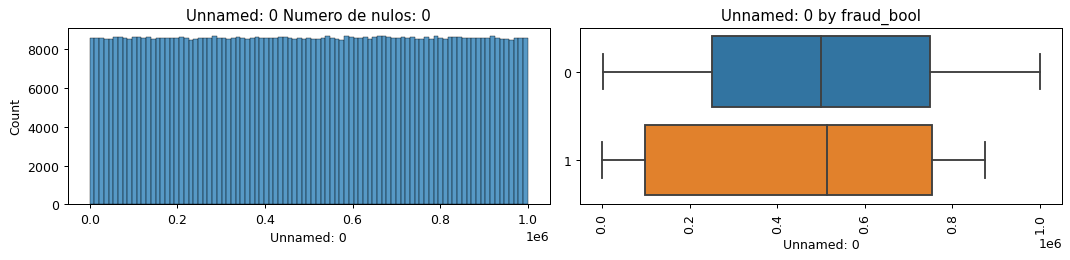

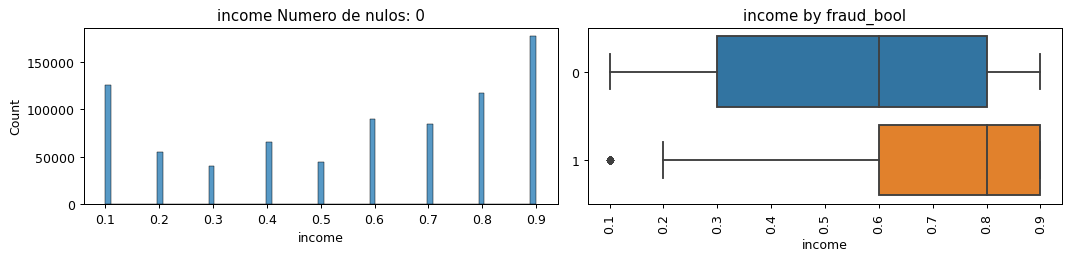

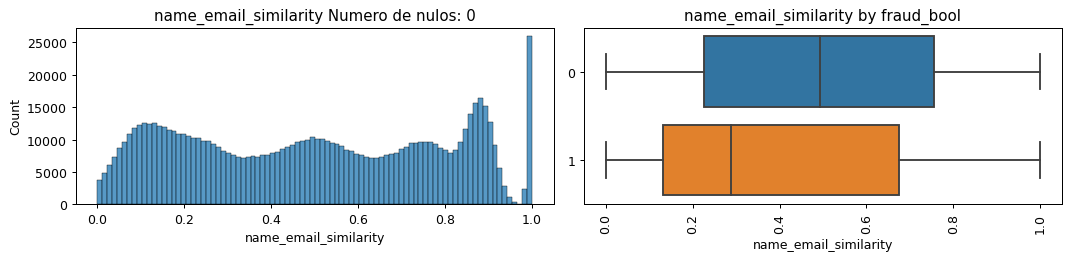

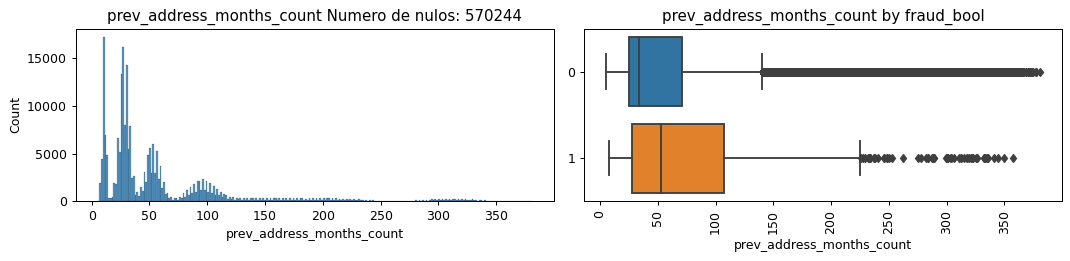

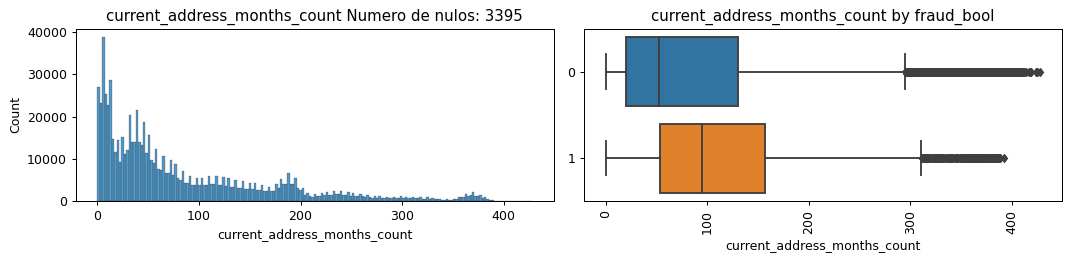

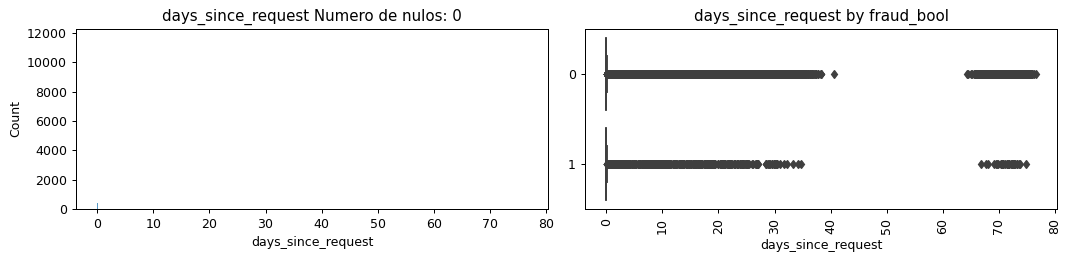

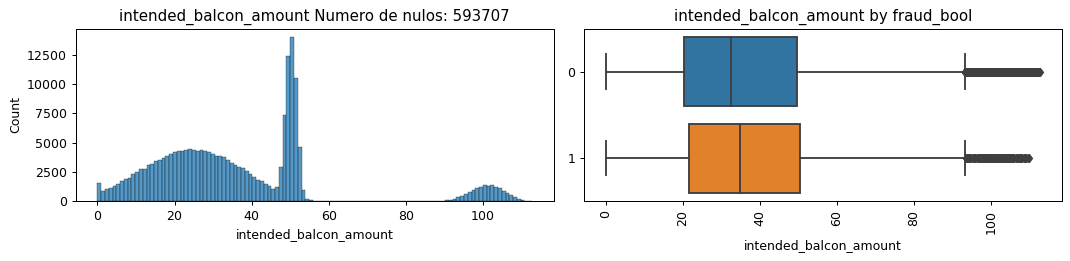

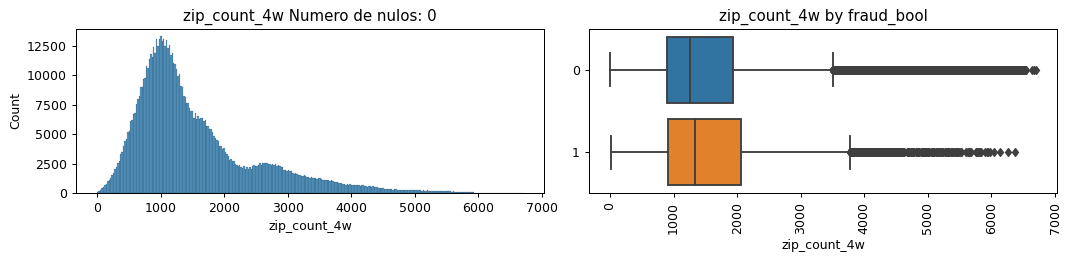

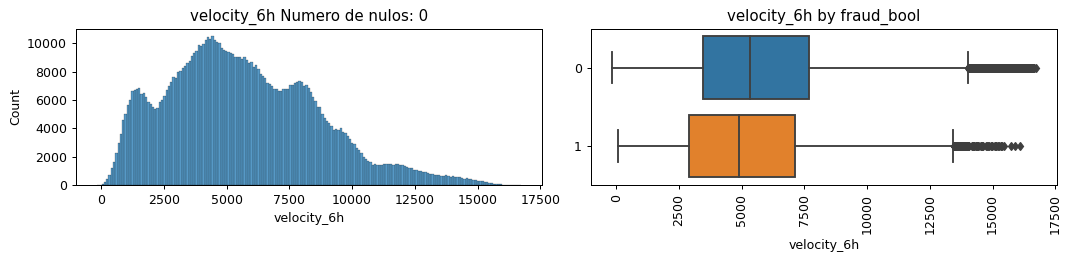

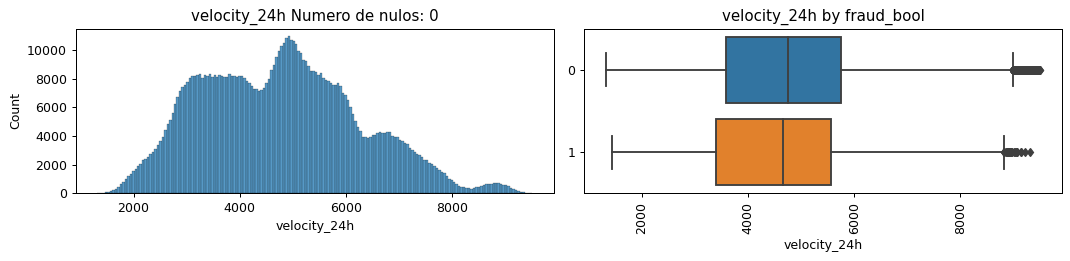

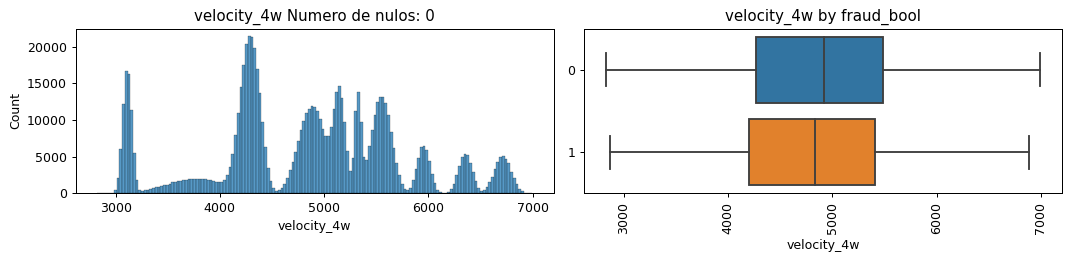

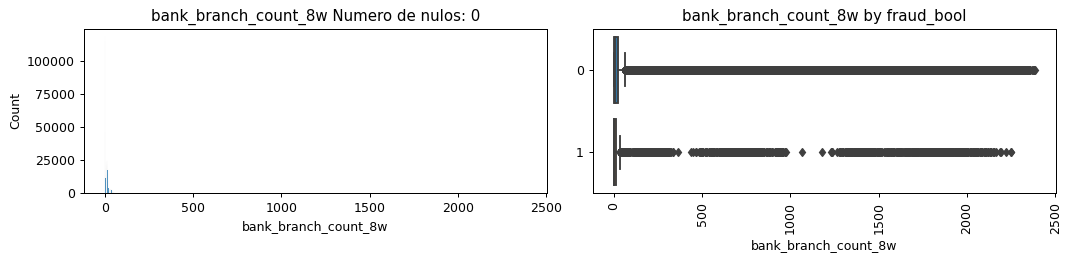

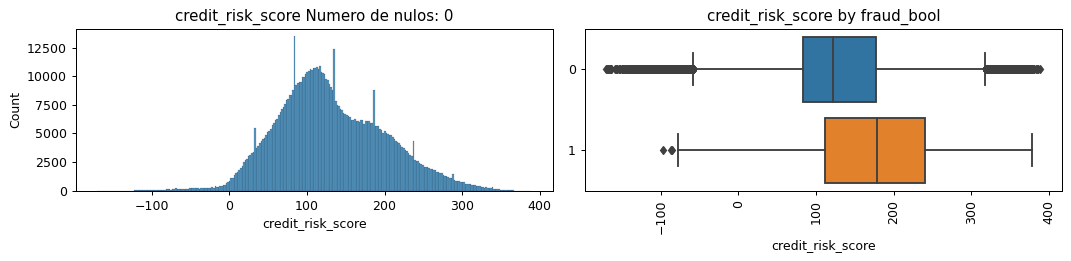

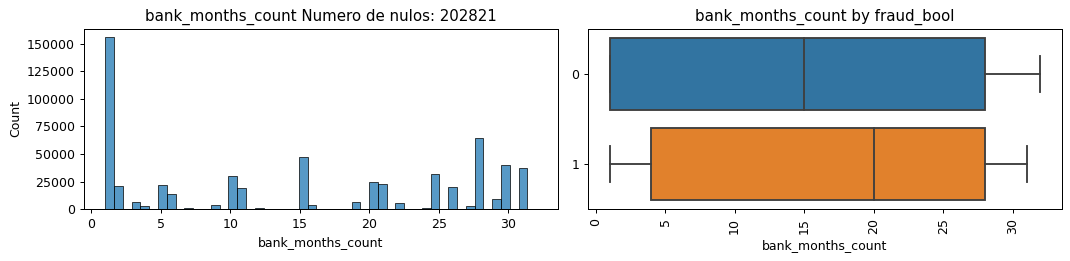

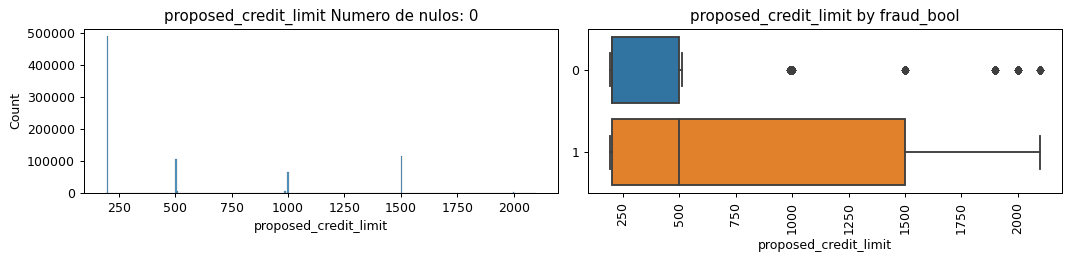

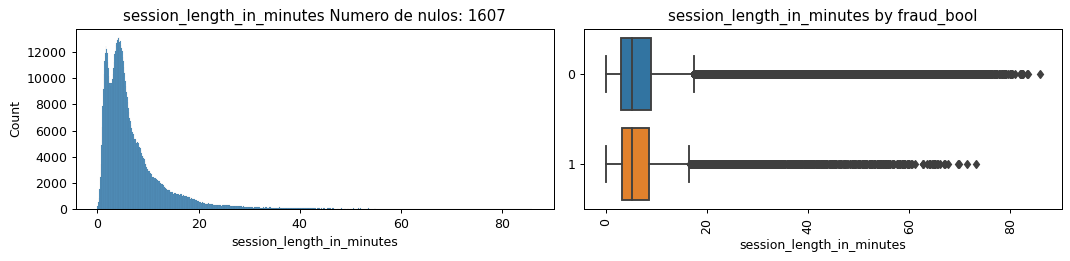

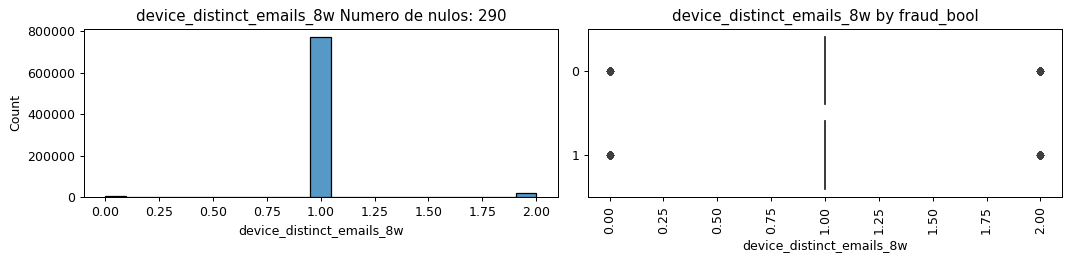

In [13]:
warnings.filterwarnings('ignore')

target = 'fraud_bool'  # Define tu columna objetivo aquí

for col_name in df_selected.columns:
    print(col_name)
    plot_feature(df_fraud_train, col_name=col_name, isContinuous=True, target=target)

Algunos de los gráficos anteriores son bastante visuales para analizar. Por ejemplo, observamos que el fraude es más común cuando el ingreso es superior. 
Otro gráfico bastante representativo es el que nos indica que las personas que comenten fraude tienen un límite superior en su cuenta bancaria. Comparando visualmente ambos gráficos, el cuartil 3 del límite bancario de las personas que no cometen fraude es aproximadamente el mismo que la mediana de los que sí comenten. Además, el cuartil 3 del límite bancario de las personas que sí cometen fraude es aproximadamente 3 veces más que los que no cometen.

### Tratamiento de las variables continuas

A continuación, se tratan los valores missing, las correlaciones de las vairbales continuas y los outlier:

In [14]:
list_var_continuous

['income',
 'name_email_similarity',
 'prev_address_months_count',
 'current_address_months_count',
 'days_since_request',
 'intended_balcon_amount',
 'velocity_6h',
 'velocity_24h',
 'velocity_4w',
 'bank_months_count',
 'proposed_credit_limit',
 'session_length_in_minutes',
 'device_distinct_emails_8w']

#### Tratamiento de outliers

Vamos a analizar la cantidad de valores outlier. Estos valores no van a ser sustituidos, tan solo analizados. 

In [15]:
get_deviation_of_mean_perc(df_fraud_train, list_var_continuous, target='fraud_bool', multiplier=3)

                   0         1
index              0         1
fraud_bool  0.993645  0.006355
                   0         1
index              0         1
fraud_bool  0.983757  0.016243
                   0         1
index              0         1
fraud_bool  0.989118  0.010882
                  0        1
index             0        1
fraud_bool  0.99013  0.00987
                   0         1
index              0         1
fraud_bool  0.993752  0.006248
                   0         1
index              0         1
fraud_bool  0.995349  0.004651
                  0        1
index             0        1
fraud_bool  0.86524  0.13476
                   0         1
index              0         1
fraud_bool  0.980139  0.019861
                   0         1
index              0         1
fraud_bool  0.963277  0.036723



,0,1,variable,sum_outlier_values,porcentaje_sum_null_values
0,0,1,prev_address_months_count,6924,0.008655
1,0.993645,0.006355,prev_address_months_count,6924,0.008655
2,0,1,current_address_months_count,16930,0.021163
3,0.983757,0.016243,current_address_months_count,16930,0.021163
4,0,1,days_since_request,14244,0.017805
5,0.989118,0.010882,days_since_request,14244,0.017805
6,0,1,intended_balcon_amount,1621,0.002026
7,0.99013,0.00987,intended_balcon_amount,1621,0.002026
8,0,1,velocity_6h,3521,0.004401
9,0.993752,0.006248,velocity_6h,3521,0.004401


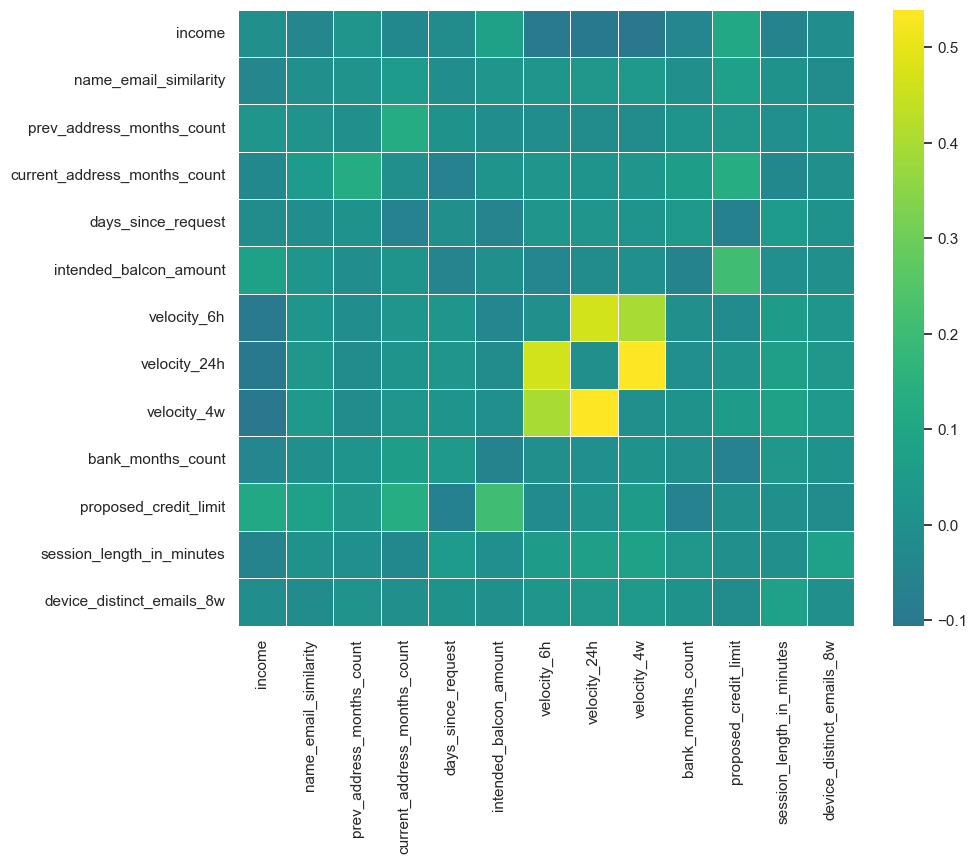

0

In [16]:
get_corr_matrix(dataset = df_fraud_train[list_var_continuous], 
                metodo='pearson', size_figure=[10,8])

In [17]:
corr = df_fraud_train[list_var_continuous].corr('pearson')
new_corr = corr.abs()
new_corr.loc[:,:] = np.tril(new_corr, k=-1) 
new_corr = new_corr.stack().to_frame('correlation').reset_index().sort_values(by='correlation', ascending=False)
new_corr[new_corr['correlation']>0.4]

,level_0,level_1,correlation
111,velocity_4w,velocity_24h,0.539675
97,velocity_24h,velocity_6h,0.464351
110,velocity_4w,velocity_6h,0.400617


Tal y como podemos observar en la tabla y el gráfico anterior, obtenemos una correlacion entre las variables "velocity_4w", "velocity_24h" y "velocity_6h", es decir, que las variables que más se correlacionan son las "velocity" entre si.

### Tratamiento de las variables categoricas

In [18]:
list_var_cat

['fraud_bool',
 'customer_age',
 'payment_type',
 'date_of_birth_distinct_emails_4w',
 'employment_status',
 'email_is_free',
 'housing_status',
 'phone_home_valid',
 'phone_mobile_valid',
 'has_other_cards',
 'foreign_request',
 'source',
 'device_os',
 'keep_alive_session',
 'device_fraud_count',
 'month']

In [19]:
df_fraud_input_train = pd.concat([df_fraud_train, df_fraud_train],axis=1).drop(list(set(list_var_continuous)),axis=1)

In [20]:
import category_encoders as ce
list_var_cat = ['customer_age', 'payment_type', 'date_of_birth_distinct_emails_4w', 'employment_status', 'email_is_free', 'housing_status', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'foreign_request', 'source', 'device_os', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

ohe = ce.OneHotEncoder(cols=list_var_cat)
model = ohe.fit(X_train, y_train)

In [21]:
import scipy.stats as ss

df_input_train = pd.DataFrame(model.transform(X_train), 
                      columns=[i+'_input' for i in list(set(list_var_continuous))],index=df_fraud_train.index)
df_input_test = pd.DataFrame(model.transform(X_test), 
                      columns=[i+'_input' for i in list(set(list_var_continuous))],index=df_fraud_test.index)

df_fraud_input_train = pd.concat([df_fraud_train, df_input_train],axis=1).drop(list(set(list_var_continuous)),axis=1)
df_fraud_input_test = pd.concat([df_fraud_test, df_input_test],axis=1).drop(list(set(list_var_continuous)),axis=1)

confusion_matrix = pd.crosstab(df_fraud_input_train["fraud_bool"], df_fraud_input_train["employment_status"])
print(confusion_matrix)
cramers_v(confusion_matrix.values)


employment_status      CA      CB     CC     CD     CE     CF   CG
fraud_bool                                                        
0                  577196  110053  29353  21106  18146  34950  373
1                    7110     750    751     88     46     72    6


0.03959635961567761

En la tabla anterior podemos ver en qué categoría de empleo se encuentran las personas que cometen fraude bancario. 

In [22]:
confusion_matrix = pd.crosstab(df_fraud_input_train["fraud_bool"], df_fraud_input_train["fraud_bool"])
cramers_v(confusion_matrix.values)

0.9999426978916621

### Guardado de la tabla

In [23]:
df_fraud_input_train.to_csv("../data/train_pd_data_preprocessing_missing_outlier.csv")
df_fraud_input_test.to_csv("../data/test_pd_data_preprocessing_missing_outlier.csv")

In [24]:
print(df_fraud_input_train.shape, df_fraud_input_test.shape)

(800000, 33) (200000, 33)
